# Regression with SGD
This is a demonstration of regression with stochastic gradient descent.

See [gradient_descent/model.py](gradient_descent/model.py) and [gradient_descent/model_tests.py](gradient_descent/model_tests.py).

In [20]:
from gradient_descent.Model import *
from gradient_descent.Controller import *

# The actual regressor will be context specific

## Boston Housing Data
Train a regression model on the Boston Housing Data.

In [21]:
from Data import load_housing, add_bias_dim, shift_scale
import numpy as np

((train_x, train_y), (test_x, test_y)) = load_housing()
_, offset, scale = shift_scale(train_x, with_params=True)

Training the model:

In [22]:
num_features = train_x.shape[1]
w = Parameter("w", init=np.random.normal(size=(num_features,)))
x = Placeholder("x", (num_features,))
y = Placeholder("y", (1, 1))

norm_x = Scale(Const(scale), Difference(x, Const(offset)))
r = Sum(Dot(w, norm_x), Const(np.average(train_y)))
loss = MSE(r, y)

model = DFBuilder().loss(loss).input(x).output(r).target(y).compile()

model.gradient_descent(train_x, train_y, n_iter=10000, learn_rate=0.01)

print("Average MSE loss on train set: {0}".format(2 * model.mean_loss(train_x, train_y)))
print("Average MSE loss on test set: {0}".format(2 * model.mean_loss(test_x, test_y)))

Average MSE loss on train set: 24.471426122401294
Average MSE loss on test set: 20.947174646635744


# Spambase Data
Train a regression model on the Spambase data

In [23]:
from Data import load_spambase, shift_scale
import numpy as np

all_x, all_y = load_spambase()
_, offset, scale = shift_scale(all_x, with_params=True)

Training the model:

In [24]:
from gradient_descent.Model import *

num_features = all_x.shape[1]
w = Parameter("w", init=np.random.normal(size=(num_features,)))
x = Placeholder("x", (num_features,))
y = Placeholder("y", (1, 1))

norm_x = Scale(Const(scale), Difference(x, Const(offset)))
r = Sum(Dot(w, norm_x), Const(np.average(all_y)))
loss = MSE(r, y)

model = DFBuilder().loss(loss).input(x).output(r).target(y).compile()

Evaluate the model:

In [25]:
from Testing import Wrapper, KFolds

classification_accuracy = lambda x, y: 1 - np.sum(np.absolute((model.eval(x) > 0.5).astype(int) - y))/len(x)
wrapped_model = Wrapper(model, model.gradient_descent, classification_accuracy)
kfolder = KFolds(wrapped_model)
kfolder.testing_error(all_x, all_y, verbose=True, n_iter=10000, learn_rate=0.1)

Running k-folds, k=5
	- Iteration 1: testing error 0.8968512486427795
	- Iteration 2: testing error 0.9043478260869565
	- Iteration 3: testing error 0.9239130434782609
	- Iteration 4: testing error 0.9119565217391304
	- Iteration 5: testing error 0.9163043478260869
Average testing error across 5 folds: 0.910674597554643


0.910674597554643

In [26]:
from gradient_descent.View import *

v = BinaryEvaluator(model)

v.confusion_matrix(all_x, all_y.reshape((-1, 1)))

pos     neg
true   1609.0  2608.0
false   180.0   204.0

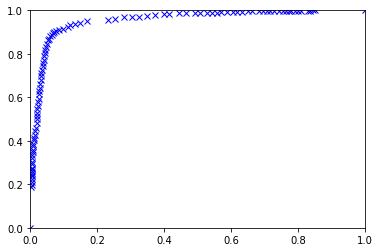

0.9585992604029087


In [27]:
v.show_roc(all_x, all_y, thresholds=[-10] + [0.01 * i for i in range(101)] + [10])
print(v.auc(all_x, all_y, thresholds=[-10] + [0.01 * i for i in range(101)] + [10]))